<a href="https://colab.research.google.com/github/diggs1711/comma-ai-speed-challenge/blob/master/speed_challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
%matplotlib inline
from cv2 import VideoCapture
from google.colab.patches import cv2_imshow
import numpy as np
import pandas as pd
import gc
import math

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
from pathlib import Path
drive_path = Path('/content/drive/My Drive/comma_ai_speed_challenge/speedchallenge-master/data/')

In [3]:
drive_path

PosixPath('/content/drive/My Drive/comma_ai_speed_challenge/speedchallenge-master/data')

In [0]:
train_vals = np.array(pd.read_fwf(drive_path/'train.txt', header=None))

In [0]:
# print(f"mean {train_vals.mean()}")
# print(f"max {train_vals.max()}")
# print(f"std {train_vals.std()}")
# print(f"min {train_vals.min()}")

# idx = int(len(train_vals) / 2)
# print()
# print("*** First half of video ****")
# first_half = train_vals[:idx]
# print(f"mean 1st {first_half.mean()}")
# print(f"max 1st {first_half.max()}")
# print(f"std 1st {first_half.std()}")
# print(f"min 1st {first_half.min()}")

# print()
# print("*** Second half of video ****")
# second_half = train_vals[idx:]
# print(f"mean 2nd {second_half.mean()}")
# print(f"max 2nd {second_half.max()}")
# print(f"std 2nd {second_half.std()}")
# print(f"min 2nd {second_half.min()}")

In [0]:
numberOfFrame = 20400
fps = 20
cropped_image_height = 66
cropped_image_width = 224

In [0]:
# load video frame by frame
cap = VideoCapture(str(drive_path/'train.mp4'))
i = 0
video_frames = []

while i < numberOfFrame:
  ret_val, frame = cap.read()
  cropped_image = frame[210:210+66,208:-208,:]
  scaled = np.array(cropped_image) / 255
  video_frames.append(scaled.astype('float16'))
  i = i + 1

cap.release()

In [8]:
del cap, frame, cropped_image
gc.collect()

253

In [0]:
# video_frames = np.array(video_frames)

In [0]:
# np.save(str(drive_path/'video_frames'), video_frames)

In [0]:
# video_frames = np.load(str(drive_path/'video_frames.npy')) / 255

In [0]:
def chunk_video(data, target_data=None):
  chunk_size = 100
  result = []
  target = []
  i = 1
  while i < len(data):
    if i % chunk_size == 0:
      result.append(data[i-chunk_size:i])
      if target_data is not None:
        target.append(target_data[i-chunk_size:i])
    i = i + 1

  return result, target

In [0]:
X, y = chunk_video(video_frames, train_vals)

In [0]:
# create train and validation sets
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

In [13]:
del video_frames, train_vals;
gc.collect()

0

In [18]:
np.array(X_train).shape

(162, 100, 66, 224, 3)

In [0]:
# X_train = X_train[..., np.newaxis]
# y_train = y_train

# X_valid = X_valid[..., np.newaxis]
# y_valid = y_valid

In [0]:
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalMaxPooling2D, TimeDistributed, LSTM
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.models import Sequential
from tensorflow.keras import Model, Input
import tensorflow.keras.backend as k

k.set_image_data_format('channels_last')

def build_model():
    k.clear_session()
    base_model = Xception(weights='imagenet', include_top=False)

    img_input = Input(shape=(None, cropped_image_height, cropped_image_width, 3))

    x = TimeDistributed(base_model)(img_input)
    x = TimeDistributed(GlobalMaxPooling2D())(x)
    x = TimeDistributed(Flatten())(x)
    x = LSTM(32, return_sequences=True)(x)
    x = TimeDistributed(Dense(20, activation='relu'))(x)
    output = TimeDistributed(Dense(1, activation='relu'))(x)
    mod = Model(inputs=img_input, outputs=output)

    for l in base_model.layers:
        l.trainable = False
    
    mod.compile('adam', 'mse')
    return mod

In [0]:
model = build_model()

In [0]:
X_train = np.array(X_train, copy=False)

In [0]:
X_valid = np.array(X_valid, copy=False)

In [0]:
y_train = np.array(y_train, copy=False).astype('float32')

In [0]:
y_valid =  np.array(y_valid, copy=False).astype('float32')

In [0]:
np.save(drive_path/'x_train.npy', X_train)
np.save(drive_path/'x_valid.npy', X_valid)
np.save(drive_path/'y_train.npy', y_train)
np.save(drive_path/'y_valid.npy', y_valid)

In [0]:
X_train = np.load(drive_path/'x_train.npy', allow_pickle=True)
X_valid = np.load(drive_path/'x_valid.npy', allow_pickle=True)
y_train = np.load(drive_path/'y_train.npy', allow_pickle=True)
y_valid = np.load(drive_path/'y_valid.npy', allow_pickle=True)

In [29]:
gc.collect()

0

In [30]:
X_train.shape

(162, 100, 66, 224, 3)

In [31]:
y_train.shape

(162, 100, 1)

In [38]:
X_valid.shape

(41, 100, 66, 224, 3)

In [39]:
history = model.fit(
    X_train,
    y_train,
    epochs=30,
    batch_size=8,
    validation_data=(X_valid, y_valid)
)

Epoch 1/30
21/21 [==============================] - 15s 719ms/step - loss: 20.1619 - val_loss: 18.5887
Epoch 2/30
21/21 [==============================] - 13s 610ms/step - loss: 16.7495 - val_loss: 16.0182
Epoch 3/30
21/21 [==============================] - 13s 614ms/step - loss: 14.6082 - val_loss: 14.9092
Epoch 4/30
21/21 [==============================] - 13s 614ms/step - loss: 12.6849 - val_loss: 13.9070
Epoch 5/30
21/21 [==============================] - 13s 613ms/step - loss: 11.0266 - val_loss: 13.1391
Epoch 6/30
21/21 [==============================] - 13s 626ms/step - loss: 9.9085 - val_loss: 13.1585
Epoch 7/30
21/21 [==============================] - 13s 633ms/step - loss: 10.1606 - val_loss: 12.2926
Epoch 8/30
21/21 [==============================] - 13s 626ms/step - loss: 8.6617 - val_loss: 12.2910
Epoch 9/30
21/21 [==============================] - 13s 609ms/step - loss: 7.7563 - val_loss: 11.6789
Epoch 10/30
21/21 [==============================] - 13s 609ms/step - loss: 

In [0]:
model.save_weights(str(drive_path/'weights'))

In [7]:
model.load_weights(str(drive_path/'weights'))

In [8]:
predictions = model.predict(X_valid, batch_size=8)

NameError: ignored

In [0]:
predictions[25]

In [0]:
cv2_imshow(X_valid[25] * 255)

In [0]:
y_valid[25]

In [0]:
original_test_images = []

cap = VideoCapture(str(drive_path/'test.mp4'))
i = 0
while i < 10798:
    ret_val, frame = cap.read()
    frame = np.array(frame[210:210+66,208:-208,:]).astype('float32')
    original_test_images.append(np.array(frame) / 255)
    i = i + 1

In [0]:
original_test_images = np.array(original_test_images)

In [13]:
original_test_images.shape

(10798, 66, 224, 3)

In [0]:
X, _ = chunk_video(original_test_images)

In [0]:
X = np.array(X)

In [22]:
X.shape

(107, 100, 66, 224, 3)

In [23]:
original_test_images.shape

(10798, 66, 224, 3)

In [0]:
predictions = model.predict(X, batch_size=8)

In [0]:
predictions = predictions.ravel()

In [0]:
speed_overlayed_test_video = []

In [0]:
import cv2

for i in range(0, len(predictions)):
    original_test_images.append(cv2.putText(original_test_images[i] * 255, str(predictions[i]), (10,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,17)))

In [46]:
original_test_images.shape

(10798, 66, 224, 3)

In [0]:
np.save(drive_path/'output.npy')

In [0]:
from cv2 import VideoWriter, VideoWriter_fourcc
out = VideoWriter("output.mp4", VideoWriter_fourcc(*'mp4v'), 20, (224, 66), True)

In [0]:
speed_overlayed_test_video = np.array(speed_overlayed_test_video).astype(np.uint8)

In [0]:
original_test_images = original_test_images.astype('uint8')

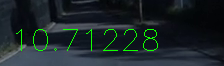

In [37]:
cv2_imshow(speed_overlayed_test_video[9])

In [0]:
for i in range(len(speed_overlayed_test_video)):
    out.write(speed_overlayed_test_video[i])
out.release()

In [0]:
from google.colab import files
files.download('output.mp4') 

In [111]:
!pip install -I scipy==1.2.*

     |████████████████████████████████| 24.8MB 129kB/s 
     |████████████████████████████████| 20.2MB 176kB/s 
ERROR: umap-learn 0.4.2 has requirement scipy>=1.3.1, but you'll have scipy 1.2.3 which is incompatible.
ERROR: tensorflow 2.2.0rc4 has requirement scipy==1.4.1; python_version >= "3", but you'll have scipy 1.2.3 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.


In [112]:
from vis.visualization import visualize_saliency

ImportError: ignored